# Metcalfe's Law and Bitcoin Price


The aim of this notebook is provide BTC price range estimate based the the amount of BTC wallets using [Metcalfe's Law](https://en.wikipedia.org/wiki/Metcalfe%27s_law).

According to [Metcalfe's Law](https://en.wikipedia.org/wiki/Metcalfe%27s_law) a value of networks (fully deluted market cap) is proportinal to the number of possible connection between their participants (wallets). As each partcipant can have _n-1_ connection, the value of the network, not cosidering the cost of the network, is :

> V=An(n-1)/2

If n is large and k=A/2 :

> V = k * n^2

_n_ is equated to the number of BTC addresses (_addressesCount_) holding more than certain amount of BTC (0.1/0.01/0.001)


In [1]:
import requests
import json
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from datetime import datetime
import time

# ----- User Settings 

collectDataFrom = pd.Timestamp('2016-02-01')

# cryptocompare.com API Key
cryptocompare_api_key = '777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49'

# Having more or same BTC as [x,y,z]. This is for filtering out empty wallets
min_btcs =  [0.001, 0.01] 
# Reuqested Simple Moving Averages for calucating k
smas = [7,30,90,180, 365]
# ----- User Settings -- end

coins=['BTC']  # Only BTC is available at cryptocompare



requestUrls = ['https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym={}&api_key={}&toTs={}&limit={}',
              'https://min-api.cryptocompare.com/data/v2/histoday?fsym={}&tsym=USD&api_key={}&toTs={}&limit={}']


limit=2000
coin_dfs=[]
for coin in coins:
    time_segments = []
    timestamp = pd.Timestamp.now()
    while collectDataFrom <= timestamp : 
        segment_dfs = []
        for requestUrl in requestUrls:
            segment_df = pd.DataFrame()
            requestUrl = requestUrl.format(coin, cryptocompare_api_key, timestamp.timestamp(),limit)
            # print("Request : " + requestUrl)    
            response = requests.get(requestUrl).text 
            parsed = json.loads(response)
            # print("Json : \n\n" + response)
            segment_df = pd.DataFrame(parsed['Data']['Data'])
            segment_df['time'] = pd.to_datetime(segment_df['time'], unit='s')
            segment_df.set_index(['time'],inplace=True, verify_integrity = True, drop = True)
            segment_df.sort_index(inplace=True)
            segment_dfs.append(segment_df)
        
        #segment_df.drop_duplicates(inplace=True)
        concated_segment_dfs= pd.concat(segment_dfs,axis=1)
        time_segments.append(concated_segment_dfs) 
        
        timestamp = segment_df.first_valid_index() - pd.Timedelta(1, "d") # -1 day    
        concated_segment_dfs.drop(columns=['volumefrom','volumeto','conversionType'
                                           ,'conversionSymbol', 'open','high','low'
                                           ,'id','symbol','partner_symbol'], inplace=True)
        #print("seg tail {}".format(concated_segment_dfs.tail(1)))

    df = pd.concat(time_segments, axis=0)
    df.sort_index(inplace=True)
    # print("Df {}\n".format(df))    
    df.dropna(inplace=True)
    df_wallet_ranges = [] 
    for i in range(10):
        df_wallet_range = pd.DataFrame()
        df_wallet_range['addressesCount'] = df['balance_distribution'].map(lambda x: x[i]['addressesCount'])
        df_wallet_range['totalVolume'] = df['balance_distribution'].map(lambda x: x[i]['totalVolume'])
        vindex= df.first_valid_index()  
        range_name = "{}-{}".format(df.loc[vindex,['balance_distribution']][0][i]['from'], 
                                    df.loc[vindex,['balance_distribution']][0][i]['to'])
        df_wallet_range =  pd.concat({range_name: df_wallet_range}, axis=1, names=["wallet_range", "metrics"]) 
        df_wallet_ranges.append(df_wallet_range)
    range_name = "all"
    df_wallet_range = pd.DataFrame()
    df_wallet_range['price'] = df['close']
    df_wallet_range = pd.concat({range_name: df_wallet_range}, axis=1, names=["wallet_range", "metrics"]) 
    df_wallet_ranges.append(df_wallet_range)
    
    df = pd.concat(df_wallet_ranges, axis=1)
 
    df = pd.concat({coin: df}, axis=1, names=["coin", "wallet_range", "metrics"])
    coin_dfs.append(df)
df=pd.concat(coin_dfs, axis=1)
df=df.loc[collectDataFrom:]
df.sort_index(inplace=True)
df

coin                    BTC                                            \
wallet_range    1e-08-0.001                  0.001-0.01                 
metrics      addressesCount  totalVolume addressesCount   totalVolume   
time                                                                    
2016-02-01          3720460   597.818519        1122004   4019.900070   
2016-02-02          3730327   599.549933        1116246   3992.645470   
2016-02-03          3729060   599.081318        1117260   3999.050294   
2016-02-04          3734713   600.356205        1124074   4024.115666   
2016-02-05          3738924   601.987694        1118292   4002.791264   
...                     ...          ...            ...           ...   
2023-04-10         23695459  4860.774117       10599328  39730.838061   
2023-04-11         23705931  4858.361665       10585073  39706.346778   
2023-04-12         23718560  4863.203260       10560736  39509.642661   
2023-04-13         23738023  4868.056573       10548631  39426.340423   
2023-04-14         23764108  4881.698146       10555888  39423.594709   

coin                                                                     \
wallet_range       0.01-0.1                         0.1-1                 
metrics      addressesCount    totalVolume addressesCount   totalVolume   
time                                                                      
2016-02-01          1232978   38923.513493         677051  2.131989e+05   
2016-02-02          1234923   38917.038726         570656  1.935706e+05   
2016-02-03          1143493   35344.645124         572704  1.941985e+05   
2016-02-04          1152587   35647.296708         579998  1.967851e+05   
2016-02-05          1158224   35818.427166         587802  1.995957e+05   
...                     ...            ...            ...           ...   
2023-04-10          7471588  251246.381944        3312842  1.030231e+06   
2023-04-11          7443767  250659.884917        3311778  1.030070e+06   
2023-04-12          7430191  250371.740559        3312434  1.030245e+06   
2023-04-13          7428931  250347.014858        3312798  1.030404e+06   
2023-04-14          7430227  250384.474559        3312891  1.030417e+06   

coin                                       ...                               \
wallet_range           1-10                ...        10-100       100-1000   
metrics      addressesCount   totalVolume  ...   totalVolume addressesCount   
time                                       ...                                
2016-02-01           321685  9.116889e+05  ...  2.639466e+06          15360   
2016-02-02           326368  9.262344e+05  ...  2.658160e+06          15384   
2016-02-03           327303  9.288237e+05  ...  2.669351e+06          15356   
2016-02-04           330281  9.368918e+05  ...  2.669699e+06          15340   
2016-02-05           333193  9.430400e+05  ...  2.661130e+06          15241   
...                     ...           ...  ...           ...            ...   
2023-04-10           837967  2.091646e+06  ...  4.439974e+06          13991   
2023-04-11           837924  2.091243e+06  ...  4.436184e+06          13812   
2023-04-12           837717  2.090593e+06  ...  4.433473e+06          13812   
2023-04-13           837903  2.090945e+06  ...  4.435094e+06          13800   
2023-04-14           837948  2.091278e+06  ...  4.435301e+06          13800   

coin                                                                    \
wallet_range                   1000-10000                 10000-100000   
metrics        totalVolume addressesCount   totalVolume addressesCount   
time                                                                     
2016-02-01    3.517520e+06           1667  3.385247e+06            105   
2016-02-02    3.514005e+06           1666  3.358658e+06            107   
2016-02-03    3.510309e+06           1664  3.358865e+06            107   
2016-02-04    3.502746e+06           1656  3.335922e+06            108   


In [2]:
df_aux = pd.DataFrame()

coin = 'BTC'

#aggregate_wallets=['0.1-1','1-10', '10-100','100-1000', '1000-10000', '10000-100000', '100000-1000000']
aggregate_wallets=['1-10', '10-100','100-1000', '1000-10000', '10000-100000']


#aggregate_wallets.append('1-10')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'1+','addressesCount')] = df_aux['addressesCount']

aggregate_wallets.append('0.1-1')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.1+','addressesCount')] = df_aux['addressesCount']


aggregate_wallets.append('0.01-0.1')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.01+','addressesCount')] = df_aux['addressesCount']


aggregate_wallets.append('0.001-0.01')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.001+','addressesCount')] = df_aux['addressesCount']
df.drop(columns=['100000-0','1e-08-0.001',*aggregate_wallets],inplace=True,level= "wallet_range")


df

coin               BTC                                               \
wallet_range       all             1+           0.1+          0.01+   
metrics          price addressesCount addressesCount addressesCount   
time                                                                  
2016-02-01      372.18         430531        1107582        2340560   
2016-02-02      373.92         436115        1006771        2241694   
2016-02-03      368.02         437748        1010452        2153945   
2016-02-04      390.65         440597        1020595        2173182   
2016-02-05      386.46         442914        1030716        2188940   
...                ...            ...            ...            ...   
2023-04-10    29654.81         993985        4306827       11778415   
2023-04-11    30226.10         993653        4305431       11749198   
2023-04-12    29905.20         993381        4305815       11736006   
2023-04-13    30404.37         993660        4306458       11735389   
2023-04-14    30493.01         993736        4306627       11736854   

coin                         
wallet_range         0.001+  
metrics      addressesCount  
time                         
2016-02-01          3462564  
2016-02-02          3357940  
2016-02-03          3271205  
2016-02-04          3297256  
2016-02-05          3307232  
...                     ...  
2023-04-10         22377743  
2023-04-11         22334271  
2023-04-12         22296742  
2023-04-13         22284020  
2023-04-14         22292742  

[2630 rows x 5 columns]

In [3]:
def convert_to_m2(df,dt):
    iloc_idx = df.index.get_indexer([dt], method='nearest')  # returns absolute index into df e.g. array([5])
    loc_idx = df.index[iloc_idx]                             # if you want named index
    # my_val = df.iloc[iloc_idx]
    return df.loc[loc_idx,'WM2NS'].values[0] 
df_m2 = pd.read_csv('data/WM2NS.csv')
df_m2['DATE']= pd.to_datetime(df_m2['DATE'])
df_m2.set_index(['DATE'],inplace=True, verify_integrity = True, drop = True)
df.loc(axis=1)[('USD','all', 'm2_supply')] = df.index.map(lambda dt: convert_to_m2(df_m2,dt))

btc_birthday = pd.to_datetime('2009-01-03')
m2_supply_at_genesis = convert_to_m2(df_m2,btc_birthday)
df.loc(axis=1)[('USD','all', 'm2_supply_index')] = df.loc(axis=1)[('USD','all', 'm2_supply')]/m2_supply_at_genesis
df.loc(axis=1)[('BTC','all', 'm2_adj_price')] = df.loc(axis=1)[('BTC','all', 'price')] /df.loc(axis=1)[('USD','all', 'm2_supply_index')]
df


coin               BTC                                               \
wallet_range       all             1+           0.1+          0.01+   
metrics          price addressesCount addressesCount addressesCount   
time                                                                  
2016-02-01      372.18         430531        1107582        2340560   
2016-02-02      373.92         436115        1006771        2241694   
2016-02-03      368.02         437748        1010452        2153945   
2016-02-04      390.65         440597        1020595        2173182   
2016-02-05      386.46         442914        1030716        2188940   
...                ...            ...            ...            ...   
2023-04-10    29654.81         993985        4306827       11778415   
2023-04-11    30226.10         993653        4305431       11749198   
2023-04-12    29905.20         993381        4305815       11736006   
2023-04-13    30404.37         993660        4306458       11735389   
2023-04-14    30493.01         993736        4306627       11736854   

coin                              USD                           BTC  
wallet_range         0.001+       all                           all  
metrics      addressesCount m2_supply m2_supply_index  m2_adj_price  
time                                                                 
2016-02-01          3462564   12454.7        1.494803    248.982614  
2016-02-02          3357940   12454.7        1.494803    250.146647  
2016-02-03          3271205   12454.7        1.494803    246.199639  
2016-02-04          3297256   12454.7        1.494803    261.338756  
2016-02-05          3307232   12467.4        1.496327    258.272352  
...                     ...       ...             ...           ...  
2023-04-10         22377743   21149.1        2.538298  11682.949956  
2023-04-11         22334271   21149.1        2.538298  11908.018081  
2023-04-12         22296742   21149.1        2.538298  11781.594791  
2023-04-13         22284020   21149.1        2.538298  11978.250178  
2023-04-14         22292742   21149.1        2.538298  12013.171214  

[2630 rows x 8 columns]

In [4]:

btc_max_supply = 21*10**6
for min_btc in min_btcs:
    df.loc(axis=1)[(coin,str(min_btc) + '+','k')] = btc_max_supply*df.loc(axis=1)[(coin,'all','m2_adj_price')] \
        / ( df.loc(axis=1)[(coin, str(min_btc) + '+','addressesCount')] \
        * df.loc(axis=1)[(coin, str(min_btc) + '+','addressesCount')])
    for days in smas: 
        df.loc(axis=1)[(coin, str(min_btc) + '+', 'k-sma' + str(days) +'d')] = \
            df.loc(axis=1)[(coin, str(min_btc) + '+','k')].rolling(days).mean()

# df=df.loc['2013-01-01':]
df

coin               BTC                                               \
wallet_range       all             1+           0.1+          0.01+   
metrics          price addressesCount addressesCount addressesCount   
time                                                                  
2016-02-01      372.18         430531        1107582        2340560   
2016-02-02      373.92         436115        1006771        2241694   
2016-02-03      368.02         437748        1010452        2153945   
2016-02-04      390.65         440597        1020595        2173182   
2016-02-05      386.46         442914        1030716        2188940   
...                ...            ...            ...            ...   
2023-04-10    29654.81         993985        4306827       11778415   
2023-04-11    30226.10         993653        4305431       11749198   
2023-04-12    29905.20         993381        4305815       11736006   
2023-04-13    30404.37         993660        4306458       11735389   
2023-04-14    30493.01         993736        4306627       11736854   

coin                              USD                           BTC            \
wallet_range         0.001+       all                           all    0.001+   
metrics      addressesCount m2_supply m2_supply_index  m2_adj_price         k   
time                                                                            
2016-02-01          3462564   12454.7        1.494803    248.982614  0.000436   
2016-02-02          3357940   12454.7        1.494803    250.146647  0.000466   
2016-02-03          3271205   12454.7        1.494803    246.199639  0.000483   
2016-02-04          3297256   12454.7        1.494803    261.338756  0.000505   
2016-02-05          3307232   12467.4        1.496327    258.272352  0.000496   
...                     ...       ...             ...           ...       ...   
2023-04-10         22377743   21149.1        2.538298  11682.949956  0.000490   
2023-04-11         22334271   21149.1        2.538298  11908.018081  0.000501   
2023-04-12         22296742   21149.1        2.538298  11781.594791  0.000498   
2023-04-13         22284020   21149.1        2.538298  11978.250178  0.000507   
2023-04-14         22292742   21149.1        2.538298  12013.171214  0.000508   

coin                                                                      \
wallet_range                                                       0.01+   
metrics        k-sma7d  k-sma30d  k-sma90d k-sma180d k-sma365d         k   
time                                                                       
2016-02-01         NaN       NaN       NaN       NaN       NaN  0.000954   
2016-02-02         NaN       NaN       NaN       NaN       NaN  0.001045   
2016-02-03         NaN       NaN       NaN       NaN       NaN  0.001114   
2016-02-04         NaN       NaN       NaN       NaN       NaN  0.001162   
2016-02-05         NaN       NaN       NaN       NaN       NaN  0.001132   
...                ...       ...       ...       ...       ...       ...   
2023-04-10    0.000467  0.000453  0.000411  0.000360  0.000419  0.001768   
2023-04-11    0.000471  0.000457  0.000413  0.000361  0.000418  0.001812   
2023-04-12    0.000476  0.000460  0.000415  0.000362  0.000417  0.001796   
2023-04-13    0.000482  0.000463  0.000417  0.000363  0.000416  0.001826   
2023-04-14    0.000490  0.000467  0.000418  0.000363  0.000416  0.001831   

coin                                                            
wallet_range                                                    
metrics        k-sma7d  k-sma30d  k-sma90d k-sma180d k-sma365d  
time                                                            
2016-02-01         NaN       NaN       NaN       NaN       NaN  
2016-02-02         NaN       NaN       NaN       NaN       NaN  
2016-02-03         NaN       NaN       NaN       NaN       NaN  
2016-02-04         NaN       NaN       NaN       NaN       NaN  
2016-02-05         NaN       NaN       NaN       NaN     

In [5]:
ranges_from_sma_days = 30

for min_btc in min_btcs:
    wallet_range = str(min_btc) + '+'
    k_btc_bottom = df['BTC',wallet_range,'k-sma'+ str(ranges_from_sma_days)+ 'd'].min()/btc_max_supply
    k_btc_top = df['BTC', wallet_range,'k-sma'+ str(ranges_from_sma_days)+ 'd'].max()/btc_max_supply
    df.loc(axis=1)[(coin, wallet_range, 'k_btc_bottom')] = k_btc_bottom
    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_bottom_price')] = \
        k_btc_bottom * df.loc(axis=1)[(coin,wallet_range,'addressesCount')]**2
    df.loc(axis=1)[(coin, wallet_range, 'bottom_price')] = \
        df.loc(axis=1)[(coin,wallet_range, 'm2_adj_bottom_price')] * df.loc(axis=1)[('USD','all', 'm2_supply_index')]
    df.loc(axis=1)[(coin, wallet_range, 'k_btc_top')] = k_btc_top
    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_top_price')] = \
        k_btc_top * df.loc(axis=1)[(coin,wallet_range,'addressesCount')]**2
    df.loc(axis=1)[(coin, wallet_range, 'top_price')] = \
        df.loc(axis=1)[(coin,wallet_range, 'm2_adj_top_price')] * df.loc(axis=1)[('USD','all', 'm2_supply_index')]
    print("k top-to-bottom ratio is {} at range {} using k-sma-{}d ".format(k_btc_top/k_btc_bottom,min_btc,ranges_from_sma_days ) )

k top-to-bottom ratio is 5.39628907243339 at range 0.001 using k-sma-30d 
k top-to-bottom ratio is 7.967786720265943 at range 0.01 using k-sma-30d 


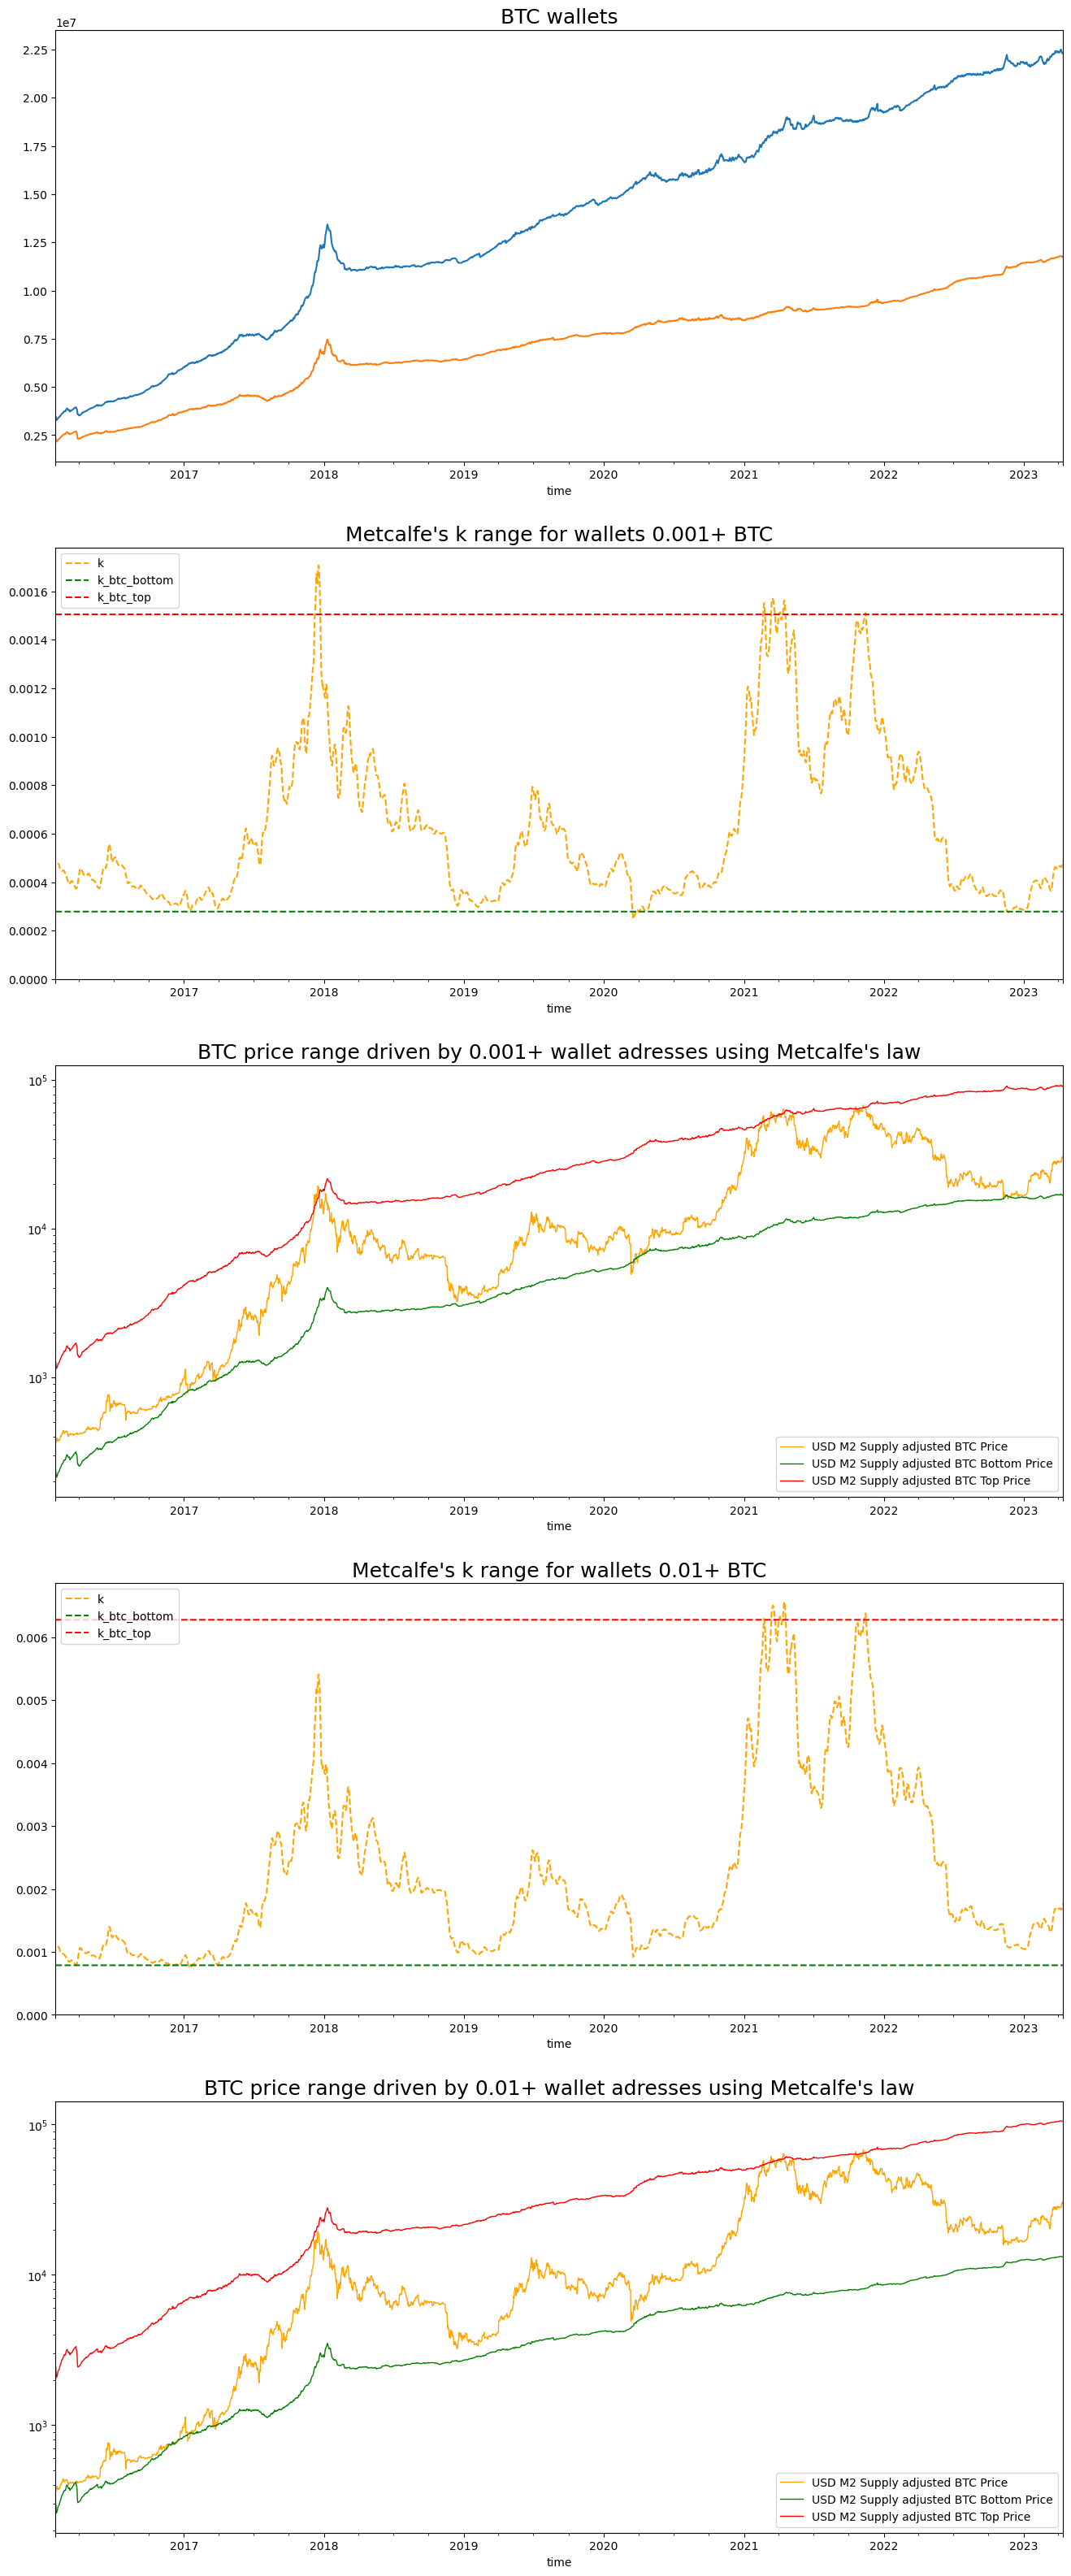

In [6]:
import matplotlib.pyplot as plt
subplots = 1+len(min_btcs)*2;
fig, axs = plt.subplots(subplots)
fig.set_size_inches(16, 8*subplots)

axs[0].set_title("{} wallets".format(coin), fontsize=18)
for min_btc in min_btcs:
    df[coin][str(min_btc)+'+']['addressesCount'].plot(ax=axs[0],label='Wallets over {} {}'.format(min_btc, coin) )
i=1
for min_btc in min_btcs:
#for i in range(1,subplots,2) :
    
    wallet_range = str(min_btc)+'+'
    axs[i].set_title("Metcalfe's k range for wallets {} {}".format(wallet_range, coin), fontsize=18)
    df[coin][wallet_range]['k-sma7d'].plot(ax=axs[i],color='orange',label='k'.format(wallet_range, coin), linestyle='dashed')
    (df[coin][wallet_range]['k_btc_bottom']*btc_max_supply).plot(ax=axs[i],color='green',label='k_btc_bottom', linestyle='dashed')
    (df[coin][wallet_range]['k_btc_top']*btc_max_supply).plot(ax=axs[i],color='red',label='k_btc_top', linestyle='dashed')
    axs[i].legend(loc='upper left')
    axs[i].set_ylim([0,None])

    axs[i+1].set_title("{} price range driven by {} wallet adresses using Metcalfe's law".format(coin, wallet_range), fontsize=18)

    #m2_adj_='m2_adj_'
    m2_adj_=''
    df[coin]['all'][m2_adj_ + 'price'].plot(ax=axs[i+1], linewidth=1, color='orange',label='USD M2 Supply adjusted {} Price'.format(coin))
    df[coin][wallet_range][m2_adj_ + 'bottom_price'].plot(ax=axs[i+1], linewidth=1,color='green',label='USD M2 Supply adjusted {} Bottom Price'.format(coin)) 
    df[coin][wallet_range][m2_adj_ + 'top_price'].plot(ax=axs[i+1], linewidth=1,color='red',label='USD M2 Supply adjusted {} Top Price'.format(coin)) 
    axs[i+1].set_yscale('log')
    axs[i+1].legend(loc='lower right')
    i=i+2